In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 8, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Conv2d(8, 16, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.15)  # Reduced dropout
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 16, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.15)  # Reduced dropout
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 16, 3, padding=1),  # Added intermediate channels
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 10, 1),  # 1x1 conv to reduce channels to num_classes
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.MaxPool2d(2, 2),
        )
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = F.adaptive_avg_pool2d(x, (1, 1))
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=1)

In [3]:
#!pip install torchinfo
from torchinfo import summary
use_cuda = torch.cuda.is_available()
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if use_cuda else "cpu")
model = Net().to(device)
# Create a dummy input tensor on the correct device
summary(model, input_size=(1, 1, 28, 28), device=device)

Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [1, 10]                   --
├─Sequential: 1-1                        [1, 16, 14, 14]           --
│    └─Conv2d: 2-1                       [1, 8, 28, 28]            80
│    └─ReLU: 2-2                         [1, 8, 28, 28]            --
│    └─BatchNorm2d: 2-3                  [1, 8, 28, 28]            16
│    └─Conv2d: 2-4                       [1, 16, 28, 28]           1,168
│    └─ReLU: 2-5                         [1, 16, 28, 28]           --
│    └─BatchNorm2d: 2-6                  [1, 16, 28, 28]           32
│    └─MaxPool2d: 2-7                    [1, 16, 14, 14]           --
│    └─Dropout: 2-8                      [1, 16, 14, 14]           --
├─Sequential: 1-2                        [1, 32, 7, 7]             --
│    └─Conv2d: 2-9                       [1, 16, 14, 14]           2,320
│    └─ReLU: 2-10                        [1, 16, 14, 14]           --
│    └─Ba

In [4]:


torch.manual_seed(1456)
batch_size = 512

kwargs = {'num_workers': 0, 'pin_memory': True} if device.type in ["cuda", "mps"] else {}
# train_loader = torch.utils.data.DataLoader(
#     datasets.MNIST('../data', train=True, download=True,
#                     transform=transforms.Compose([
#                         transforms.ToTensor(),
#                         transforms.Normalize((0.1307,), (0.3081,))
#                     ])),
#     batch_size=batch_size, shuffle=True, **kwargs)
# test_loader = torch.utils.data.DataLoader(
#     datasets.MNIST('../data', train=False, transform=transforms.Compose([
#                         transforms.ToTensor(),
#                         transforms.Normalize((0.1307,), (0.3081,))
#                     ])),
#     batch_size=batch_size, shuffle=True, **kwargs)


import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
import cv2
import random
# Define the augmentation pipeline
train_transforms = A.Compose([
    A.ShiftScaleRotate(
        shift_limit=0.0625,
        scale_limit=0.1,
        rotate_limit=15,
        p=0.7,
        border_mode=cv2.BORDER_CONSTANT,
        value=0
    ),
    A.GaussNoise(var_limit=(5.0, 30.0), p=0.3),
    A.Perspective(scale=(0.05, 0.1), p=0.3, keep_size=True, pad_mode=cv2.BORDER_CONSTANT, pad_val=0),
    A.Normalize(
        mean=[0.1307],
        std=[0.3081],
    ),
    ToTensorV2(),
])

# Custom Dataset class to work with Albumentations
class MNISTAlbumentations(datasets.MNIST):
    def __init__(self, root, train=True, download=True, transform=None):
        super().__init__(root, train=train, download=download, transform=None)
        self.transform = transform
        
    def __getitem__(self, idx):
        img, label = self.data[idx], self.targets[idx]
        
        # Convert to numpy array and add channel dimension
        img = np.array(img)
        img = np.expand_dims(img, axis=-1)  # Add channel dimension for Albumentations
        
        if self.transform is not None:
            transformed = self.transform(image=img)
            img = transformed["image"]
            
        return img, label


# Update the data loaders
train_loader = torch.utils.data.DataLoader(
    MNISTAlbumentations('../data', train=True, download=True, transform=train_transforms),
    batch_size=batch_size, shuffle=True, 
    **kwargs)

# Test transforms (only normalization, no augmentation)
test_transforms = A.Compose([
    A.Normalize(
        mean=[0.1307],
        std=[0.3081],
    ),
    ToTensorV2(),
])

test_loader = torch.utils.data.DataLoader(
    MNISTAlbumentations('../data', train=False, transform=test_transforms),
    batch_size=batch_size, shuffle=True,  
    **kwargs)

# Optional: Visualization function to check augmentations
def visualize_augmentations(dataset, idx=0, samples=5):
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(20, 4))
    for i in range(samples):
        data = dataset[idx][0]
        if isinstance(data, torch.Tensor):
            data = data.numpy()
        if data.shape[0] == 1:  # If channels first, move to last
            data = np.transpose(data, (1, 2, 0))
        plt.subplot(1, samples, i + 1)
        plt.imshow(data.squeeze(), cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.show()



/Users/dhairyashil/miniconda3/envs/erav2/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/dhairyashil/miniconda3/envs/erav2/lib/python3.12/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


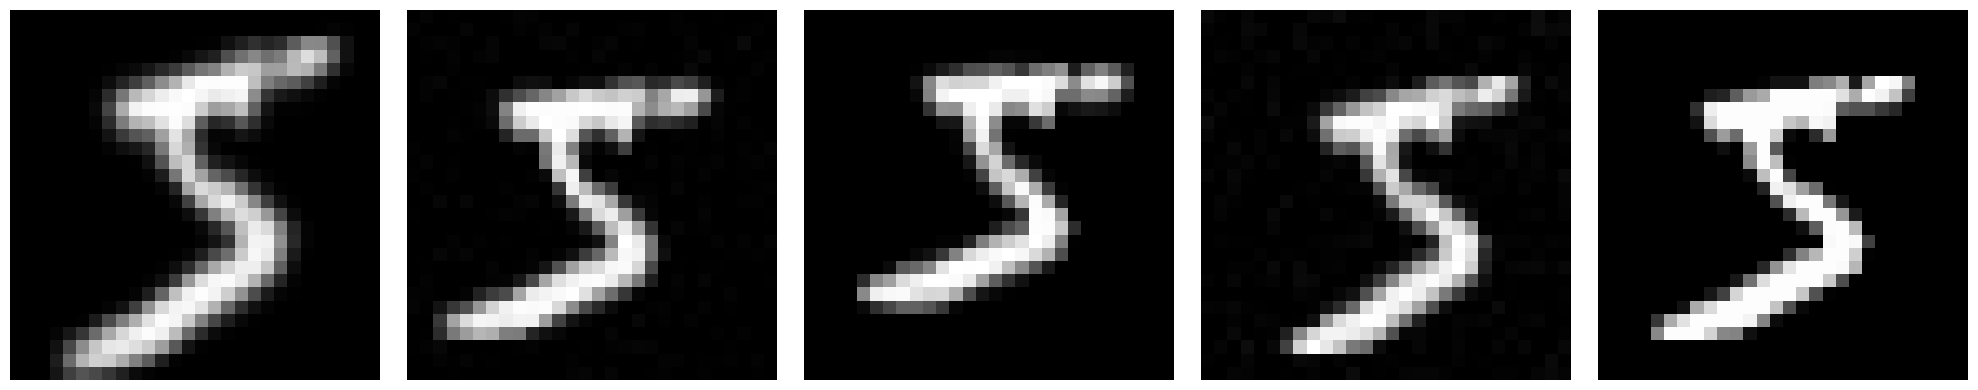

Number of samples in train dataset: 60000
Number of samples in test dataset: 10000


In [5]:
# Uncomment to visualize augmentations
visualize_augmentations(train_loader.dataset)

# # print number of samples in train and test dataset
print(f"Number of samples in train dataset: {len(train_loader.dataset)}")
print(f"Number of samples in test dataset: {len(test_loader.dataset)}")


In [6]:
from tqdm import tqdm
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx}')


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [7]:

model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
#optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

for epoch in range(1, 10):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

loss=0.43125641345977783 batch_id=117: 100%|██████████| 118/118 [00:11<00:00, 10.19it/s]



Test set: Average loss: 0.1647, Accuracy: 9605/10000 (96.05%)



loss=0.24821193516254425 batch_id=117: 100%|██████████| 118/118 [00:10<00:00, 10.85it/s]



Test set: Average loss: 0.1049, Accuracy: 9756/10000 (97.56%)



loss=0.13243888318538666 batch_id=117: 100%|██████████| 118/118 [00:11<00:00, 10.69it/s]



Test set: Average loss: 0.0625, Accuracy: 9840/10000 (98.40%)



loss=0.1165132150053978 batch_id=117: 100%|██████████| 118/118 [00:10<00:00, 10.77it/s] 



Test set: Average loss: 0.0524, Accuracy: 9874/10000 (98.74%)



loss=0.07822083681821823 batch_id=117: 100%|██████████| 118/118 [00:10<00:00, 10.83it/s]



Test set: Average loss: 0.0447, Accuracy: 9888/10000 (98.88%)



loss=0.11980058997869492 batch_id=117: 100%|██████████| 118/118 [00:11<00:00, 10.68it/s]



Test set: Average loss: 0.0430, Accuracy: 9894/10000 (98.94%)



loss=0.08553817868232727 batch_id=117: 100%|██████████| 118/118 [00:10<00:00, 10.73it/s]



Test set: Average loss: 0.0407, Accuracy: 9894/10000 (98.94%)



loss=0.08415036648511887 batch_id=117: 100%|██████████| 118/118 [00:10<00:00, 10.73it/s] 



Test set: Average loss: 0.0338, Accuracy: 9905/10000 (99.05%)



loss=0.13259628415107727 batch_id=117: 100%|██████████| 118/118 [00:10<00:00, 10.93it/s]



Test set: Average loss: 0.0353, Accuracy: 9905/10000 (99.05%)

